In [1]:
import os
from data.process_data import MidiEncoder, MIDIEncoderREMI
import pickle as pkl
from torch.utils.data import DataLoader
from data.dataset import TransformerDatasetREMI
import numpy as np
import glob
import torch
torch.manual_seed(0)

In [2]:
path_to_midi = "data/emopia/EMOPIA_2.2/midis/"

In [3]:
# Instantiate your MidiEncoder and MidiEncoderREMI
midi_files_list = [os.path.join(path_to_midi, file) for file in os.listdir(path_to_midi) if file.endswith(".mid")]
midi_encoder = MidiEncoder(steps_per_sec=100, num_vel_bins=32, min_pitch=21, max_pitch=108)
midi_encoder_remi = MIDIEncoderREMI(dict_path="data/encoder_dict.pkl", midi_files_list=midi_files_list)

In [4]:
# encoded_sequences_path = "data/encoded_sequences.pkl"
# encoded_sequences = midi_encoder.encode_midi_list(midi_files_list, pkl_path=encoded_sequences_path)

In [5]:
# Now create the dataset and save it in a NumPy file
dataset_path = "data/datasets/"
# midi_encoder_remi.save_dataset(midi_files_list, dataset_path)

In [6]:
# # Save the dataset as a single file
single_file_dataset_path = "data/single_file_dataset.npz"
# midi_encoder_remi.save_dataset_as_single_file(glob.glob(os.path.join(dataset_path, '*.npy')), single_file_dataset_path)

In [7]:
from data.dataset import ClassifierDataset
max_seq_len = 256
classifier_dataset = ClassifierDataset(single_file_dataset_path, seq_len=max_seq_len+1, labels_path="data/emopia/EMOPIA_2.2/label.csv")
train_size = int(0.7 * len(classifier_dataset))
valid_size = int(0.15 * len(classifier_dataset))
test_size = len(classifier_dataset) - train_size - valid_size
train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(classifier_dataset, [train_size, valid_size, test_size])

/workspaces/ece661-final-proj2/data/dataset.py:239: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:261.)
  self.sequences = torch.Tensor(self.sequences)


In [8]:
batch_size = 64

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=True)

In [10]:
vocab_set = set()
for dic in train_dataset:
    ipt = dic['input'].numpy()
    vocab_set = vocab_set.union(set(ipt))
vocab_size = len(vocab_set)

In [11]:
# Q1, Q2, Q3, Q4 = [], [], [], []
# for dic in classifier_dataset:
#     label = dic['target']
#     if label == 0:
#         Q1.append(dic)
#     elif label == 1:
#         Q2.append(dic)
#     elif label == 2:
#         Q3.append(dic)
#     elif label == 3:
#         Q4.append(dic)

In [12]:
# classifier_valid = {'Q1': Q1, 'Q2': Q2, 'Q3': Q3, 'Q4': Q4}

In [13]:
import math

import torch
from torch import nn, Tensor
from torch.nn import TransformerEncoder, TransformerEncoderLayer, Embedding


In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
import math

In [15]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, num_heads):
        super(MultiHeadAttention, self).__init__()
        assert d_model % num_heads == 0, "d_model must be divisible by num_heads"
        
        self.d_model = d_model
        self.num_heads = num_heads
        self.d_k = d_model // num_heads
        
        self.W_q = nn.Linear(d_model, d_model)
        self.W_k = nn.Linear(d_model, d_model)
        self.W_v = nn.Linear(d_model, d_model)
        self.W_o = nn.Linear(d_model, d_model)
        
    def scaled_dot_product_attention(self, Q, K, V, mask=None):
        attn_scores = torch.matmul(Q, K.transpose(-2, -1)) / math.sqrt(self.d_k)
        if mask is not None:
            attn_scores = attn_scores.masked_fill(mask == 0, -1e9)
        attn_probs = torch.softmax(attn_scores, dim=-1)
        output = torch.matmul(attn_probs, V)
        return output
        
    def split_heads(self, x):
        batch_size, seq_length, d_model = x.size()
        return x.view(batch_size, seq_length, self.num_heads, self.d_k).transpose(1, 2)
        
    def combine_heads(self, x):
        batch_size, _, seq_length, d_k = x.size()
        return x.transpose(1, 2).contiguous().view(batch_size, seq_length, self.d_model)
        
    def forward(self, Q, K, V, mask=None):
        Q = self.split_heads(self.W_q(Q))
        K = self.split_heads(self.W_k(K))
        V = self.split_heads(self.W_v(V))
        
        attn_output = self.scaled_dot_product_attention(Q, K, V, mask)
        output = self.W_o(self.combine_heads(attn_output))
        return output

In [16]:
class PositionWiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionWiseFeedForward, self).__init__()
        self.fc1 = nn.Linear(d_model, d_ff)
        self.fc2 = nn.Linear(d_ff, d_model)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.fc2(self.relu(self.fc1(x)))

In [17]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_seq_length):
        super(PositionalEncoding, self).__init__()
        
        pe = torch.zeros(max_seq_length, d_model)
        position = torch.arange(0, max_seq_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * -(math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        
        self.register_buffer('pe', pe.unsqueeze(0))
        
    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(EncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, mask):
        attn_output = self.self_attn(x, x, x, mask)
        x = self.norm1(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm2(x + self.dropout(ff_output))
        return x

In [19]:
class DecoderLayer(nn.Module):
    def __init__(self, d_model, num_heads, d_ff, dropout):
        super(DecoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, num_heads)
        self.cross_attn = MultiHeadAttention(d_model, num_heads)
        self.feed_forward = PositionWiseFeedForward(d_model, d_ff)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.norm3 = nn.LayerNorm(d_model)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x, enc_output, src_mask, tgt_mask):
        attn_output = self.self_attn(x, x, x, tgt_mask)
        x = self.norm1(x + self.dropout(attn_output))
        attn_output = self.cross_attn(x, enc_output, enc_output, src_mask)
        x = self.norm2(x + self.dropout(attn_output))
        ff_output = self.feed_forward(x)
        x = self.norm3(x + self.dropout(ff_output))
        return x

In [20]:
class Transformer(nn.Module):
    def __init__(self, src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, num_emotions):
        super(Transformer, self).__init__()
        self.encoder_embedding = nn.Embedding(src_vocab_size, d_model)
        self.decoder_embedding = nn.Embedding(tgt_vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.emotion_embedding = nn.Embedding(num_emotions, d_model)

        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.decoder_layers = nn.ModuleList([DecoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, tgt_vocab_size)
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src, tgt):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        tgt_mask = (tgt != 0).unsqueeze(1).unsqueeze(3)
        seq_length = tgt.size(1)
        nopeak_mask = (1 - torch.triu(torch.ones(1, seq_length, seq_length), diagonal=1)).bool().to(device)
        tgt_mask = tgt_mask & nopeak_mask
        return src_mask, tgt_mask

    def forward(self, src, tgt, emotion):
        src_mask, tgt_mask = self.generate_mask(src, tgt)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)) + self.emotion_embedding(emotion).unsqueeze(1))
        tgt_embedded = self.dropout(self.positional_encoding(self.decoder_embedding(tgt)) + self.emotion_embedding(emotion).unsqueeze(1))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        dec_output = tgt_embedded
        for dec_layer in self.decoder_layers:
            dec_output = dec_layer(dec_output, enc_output, src_mask, tgt_mask)

        output = self.fc(dec_output)
        return output

In [21]:
src_vocab_size = vocab_size
tgt_vocab_size = vocab_size
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 256
max_seq_length = max_seq_len
dropout = 0.2
epochs = 100
num_emotions = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, num_emotions).to(device)

In [22]:
def early_stopping(val_loss, epoch,best_loss,epochs_no_improve, patience=10, checkpoint_dir="checkpoints/transformer_ende_cond.pt"):
    if epoch == 0:
        torch.save(transformer.state_dict(), checkpoint_dir)
        best_loss = val_loss
        epochs_no_improve = 0
        return False, best_loss, epochs_no_improve
    else:
        if val_loss < best_loss:
            torch.save(transformer.state_dict(), checkpoint_dir)
            print(f"Saved model at epoch { epoch } with validation loss of {val_loss}")
            best_loss = val_loss
            epochs_no_improve = 0
            return False, best_loss, epochs_no_improve
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print('Early stopping!')
                return True, best_loss, epochs_no_improve
            else:
                return False, best_loss, epochs_no_improve

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(transformer.parameters(), lr=0.0001, betas=(0.9, 0.98), eps=1e-9)

best_loss = 50
epochs_no_improve = 0

# save the train valid losses for each epoch, and print them after epoch ends

train_losses = []
valid_losses = []


for epoch in range(epochs):
    transformer.train()
    train_loss = 0
    valid_loss = 0
    for batch in train_dataloader:
        src_data = batch['input'].to(device)
        # tgt_data = nn.functional.pad(src_data[:,1:], (0, 1), 'constant', 0).to(device)
        tgt_data = src_data[:, 1:].to(device)
        src_data = src_data[:, :-1]
        emotion = batch['target'].to(device)
        optimizer.zero_grad()
        output = transformer(src_data, tgt_data[:, :-1], emotion)
        loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
        loss.backward()
        optimizer.step()
        train_loss+=loss.item()
    train_losses.append(train_loss/len(train_dataloader))

    # evaluate on validation set
    transformer.eval()
    with torch.no_grad():
        for batch in valid_dataloader:
            src_data = batch['input'].to(device)
            tgt_data = src_data[:, 1:].to(device)
            # tgt_data = nn.functional.pad(src_data[:,1:], (0, 1), 'constant', 0).to(device)
            src_data = src_data[:, :-1]
            emotion = batch['target'].to(device)
            output = transformer(src_data, tgt_data[:, :-1], emotion)
            loss = criterion(output.contiguous().view(-1, tgt_vocab_size), tgt_data[:, 1:].contiguous().view(-1))
            valid_loss+=loss.item()
            
    valid_losses.append(valid_loss/len(valid_dataloader))

    print("Epoch: [ {} / {} ]; TrainLoss: {:.5f}; ValidLoss: {:.5f}".format(
        epoch, epochs, train_loss/len(train_dataloader), valid_loss/len(valid_dataloader)
    ))

    cond, best_loss, epochs_no_improve = early_stopping(valid_loss/len(valid_dataloader), epoch, best_loss,epochs_no_improve, patience=10)
    if cond:
        break

print("Training complete!")
print("Best loss: ", best_loss)

Epoch: [ 0 / 100 ]; TrainLoss: 4.24239; ValidLoss: 3.90111
Epoch: [ 1 / 100 ]; TrainLoss: 3.30567; ValidLoss: 2.76626
Saved model at epoch 1 with validation loss of 2.7662564624439585
Epoch: [ 2 / 100 ]; TrainLoss: 2.67443; ValidLoss: 2.45917
Saved model at epoch 2 with validation loss of 2.4591685208407315
Epoch: [ 3 / 100 ]; TrainLoss: 2.33260; ValidLoss: 2.14814
Saved model at epoch 3 with validation loss of 2.148142771287398
Epoch: [ 4 / 100 ]; TrainLoss: 2.10476; ValidLoss: 1.96406
Saved model at epoch 4 with validation loss of 1.9640643271532925
Epoch: [ 5 / 100 ]; TrainLoss: 1.92551; ValidLoss: 1.79616
Saved model at epoch 5 with validation loss of 1.796158324588429
Epoch: [ 6 / 100 ]; TrainLoss: 1.78548; ValidLoss: 1.65536
Saved model at epoch 6 with validation loss of 1.6553636139089412
Epoch: [ 7 / 100 ]; TrainLoss: 1.66985; ValidLoss: 1.52068
Saved model at epoch 7 with validation loss of 1.5206848057833584
Epoch: [ 8 / 100 ]; TrainLoss: 1.55711; ValidLoss: 1.39441
Saved mod

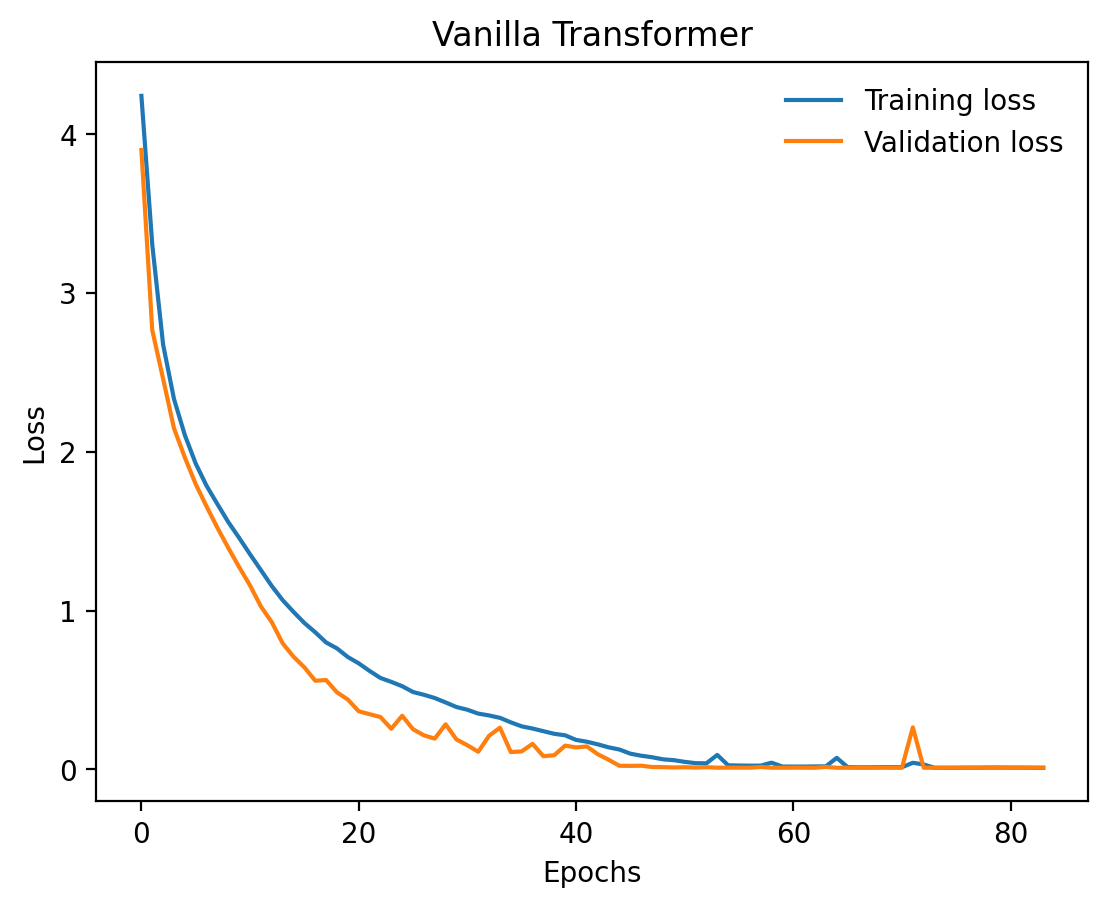

In [24]:
# plot losses
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # Makes the plots clear on high-res screens
plt.plot(train_losses, label='Training loss')
plt.plot(valid_losses, label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Vanilla Transformer")
plt.legend(frameon=False)
plt.tight_layout
plt.show()

In [24]:
# generate a sequence from the transformer model using test dataloader from the best model
transformer = Transformer(src_vocab_size, tgt_vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, num_emotions)
transformer.to(device)
transformer.load_state_dict(torch.load("checkpoints/transformer_ende_cond.pt"))

<All keys matched successfully>

In [22]:
from torch.nn.functional import softmax

In [23]:
def softmax_with_temperature(logits, temperature):
    probs = torch.nn.functional.softmax(logits / temperature, dim=-1)
    return probs
end_token_id = 1

In [24]:
def generate_sequence(model, prompt, emotion, max_length, temperature=1.0):
    model.eval()  # Set the model to inference mode

    # Tokenize the prompt
    src = prompt.to(device)
    tgt = src[:,0].unsqueeze(1).to(device)  

    for i in range(max_length):
        # Forward pass through the model
        output = model(src, tgt, emotion)  # Add emotion as required
        logits = output[:, -1, :]  # Consider only the last token's output

        # Apply temperature scaling
        probs = softmax_with_temperature(logits, temperature)

        # Sample from the probability distribution
        next_token = torch.multinomial(probs, num_samples=1)
        
        # Append to the sequence
        tgt = torch.cat((tgt, next_token), dim=1)

        # Check for end token
        if next_token.item() == end_token_id:
            break

    return tgt.squeeze().tolist()

In [24]:
max_length = 256
temperature = 1.0

for i,batch in enumerate(test_dataset):
    src_data = batch['input'].to(device)
    # tgt_data = src_data[:, 1:].to(device)
    src_data = src_data[:-1]
    emotion = batch['target'].to(device)

    generated_tokens = generate_sequence(transformer, src_data.unsqueeze(0), emotion.unsqueeze(0), max_length, temperature) 
    if emotion.item() == 0:
        emo = 'Q1'
    elif emotion.item() == 1:
        emo = 'Q2'
    elif emotion.item() == 2:
        emo = 'Q3'
    elif emotion.item() == 3:
        emo = 'Q4'
    midi_encoder_remi.words_to_midi(generated_tokens,f'generated_music_cond/transformer/{emo}/transformer{i}.mid')
    midi_encoder_remi.words_to_midi(torch.tensor(src_data, dtype=torch.long),f'generated_music_cond/original/{emo}/original{i}.mid')


In [ ]:
# import os

# for emo in ['Q1', 'Q2', 'Q3', 'Q4']:
#     dir_name = f"generated_music_cond/original/{emo}"
#     test = os.listdir(dir_name)

#     for item in test:
#         if item.endswith(".mid"):
#             os.remove(os.path.join(dir_name, item))

# for emo in ['Q1', 'Q2', 'Q3', 'Q4']:
#     dir_name = f"generated_music_cond/transformer/{emo}"
#     test = os.listdir(dir_name)

#     for item in test:
#         if item.endswith(".mid"):
#             os.remove(os.path.join(dir_name, item))

# dir_name = "generated_musics/original"
# test = os.listdir(dir_name)

# for item in test:
#     if item.endswith(".mid"):
#         os.remove(os.path.join(dir_name, item))

# GAN

In [25]:
# build a generator
class Generator(nn.Module):
    def __init__(self, vocab_size, max_seq_length, d_model, num_heads, num_layers, d_ff, dropout, num_emotions):
        super(Generator, self).__init__()
        self.transformer = Transformer(vocab_size, vocab_size, d_model, num_heads, num_layers, d_ff, max_seq_length, dropout, num_emotions)
        # self.fc = nn.Linear(dim, vocab_size)
        
    def forward(self, src, tgt, emotion):
        output = self.transformer(src, tgt, emotion)
        return output

In [26]:
class Discriminator(nn.Module):
    def __init__(self, vocab_size, max_seq_length, d_model, num_heads, num_layers, d_ff, dropout, num_emotions, num_classes):
        super(Discriminator, self).__init__()
        self.encoder_embedding = nn.Embedding(vocab_size, d_model)
        self.positional_encoding = PositionalEncoding(d_model, max_seq_length)
        self.emotion_embedding = nn.Embedding(num_emotions, d_model)
        self.encoder_layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, dropout) for _ in range(num_layers)])
        self.fc = nn.Linear(d_model, num_classes)
        self.sigmoid = nn.Sigmoid()
        self.dropout = nn.Dropout(dropout)

    def generate_mask(self, src):
        src_mask = (src != 0).unsqueeze(1).unsqueeze(2)
        return src_mask

    def forward(self, src, emotion):
        src_mask = self.generate_mask(src)
        src_embedded = self.dropout(self.positional_encoding(self.encoder_embedding(src)) + self.emotion_embedding(emotion).unsqueeze(1))

        enc_output = src_embedded
        for enc_layer in self.encoder_layers:
            enc_output = enc_layer(enc_output, src_mask)

        output,_ = torch.max(enc_output, dim=1)
        output = self.fc(output)
        output = self.sigmoid(output)
        return output

In [27]:
src_vocab_size = vocab_size
tgt_vocab_size = vocab_size
d_model = 512
num_heads = 8
num_layers = 6
d_ff = 256
max_seq_length = max_seq_len
dropout = 0.2
epochs = 100
num_emotions = 4

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [28]:
# Create the generator
netG = Generator(vocab_size, max_seq_length, d_model, num_heads, num_layers, d_ff, dropout, num_emotions).to(device)
# Create the Discriminator
netD = Discriminator(vocab_size, max_seq_length, d_model, num_heads, num_layers, d_ff, dropout, num_emotions, num_classes=1).to(device)

# Initialize the ``BCELoss`` function
criterion_BCE = nn.BCELoss()

criterion_ce = nn.CrossEntropyLoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
nz = 100
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

lr = 0.0002
beta1 = 0.5

# Setup Adam optimizers for both G and D
optimizerD = torch.optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = torch.optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [31]:
num_epochs = 5
temperature = 1.0

In [32]:
# Training Loop
# Lists to keep track of progress
txt_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for k, data in enumerate(train_dataloader):
        src_data = data['input']
        target = src_data[:, 1:].to(device)
        input = src_data[:, :-1]
        emotion = data['target'].to(device)
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = input.to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu, emotion).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion_BCE(output, label)

        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        # noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(real_cpu, target, emotion)
        fake_probabilities = nn.functional.softmax(fake.squeeze(), dim=-1)
        fake_mat = torch.zeros((b_size, max_seq_length), dtype=torch.long).to(device)
        for i in range(b_size):
            for j in range(max_seq_length):
                fake_mat[i][j] = torch.multinomial(fake_probabilities[i][j], 1).item()
        
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake_mat, emotion).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion_BCE(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        # output = netD(fake_mat).view(-1)
        # Calculate G's loss based on this output
        # errG = criterion(output, label)
        errG = criterion_ce(fake.view(-1, vocab_size), target.view(-1))
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if k % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(train_dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(train_dataloader)-1)):
            with torch.no_grad():
                fake = netG(real_cpu, target, emotion).detach().cpu()
            fake_probabilities = softmax(fake.squeeze() / temperature, dim=-1)
            fake_mat = torch.zeros((b_size, max_seq_length), dtype=torch.long).to(device)
            for i in range(b_size):
                for j in range(max_seq_length):
                    fake_mat[i][j] = torch.multinomial(fake_probabilities[i][j], 1).item()
            txt_list.append(fake_mat)

        iters += 1

Starting Training Loop...
[0/5][63/54]	Loss_D: 2.8223	Loss_G: 4.9369	D(x): 0.9325	D(G(z)): 0.9337 / 0.9337
[0/5][63/54]	Loss_D: 0.9311	Loss_G: 0.2281	D(x): 0.6678	D(G(z)): 0.2944 / 0.2944
[1/5][63/54]	Loss_D: 1.1180	Loss_G: 0.1899	D(x): 0.5534	D(G(z)): 0.2682 / 0.2682
[1/5][63/54]	Loss_D: 1.1710	Loss_G: 0.0449	D(x): 0.6165	D(G(z)): 0.4097 / 0.4097
[2/5][63/54]	Loss_D: 1.0488	Loss_G: 0.0424	D(x): 0.6197	D(G(z)): 0.3252 / 0.3252
[2/5][63/54]	Loss_D: 1.1939	Loss_G: 0.0197	D(x): 0.6377	D(G(z)): 0.4513 / 0.4513
[3/5][63/54]	Loss_D: 0.9940	Loss_G: 0.0185	D(x): 0.6726	D(G(z)): 0.3784 / 0.3784
[3/5][63/54]	Loss_D: 1.2154	Loss_G: 0.0114	D(x): 0.6069	D(G(z)): 0.4458 / 0.4458
[4/5][63/54]	Loss_D: 0.9741	Loss_G: 0.0108	D(x): 0.6188	D(G(z)): 0.3198 / 0.3198
[4/5][63/54]	Loss_D: 1.2271	Loss_G: 0.0076	D(x): 0.5986	D(G(z)): 0.4394 / 0.4394


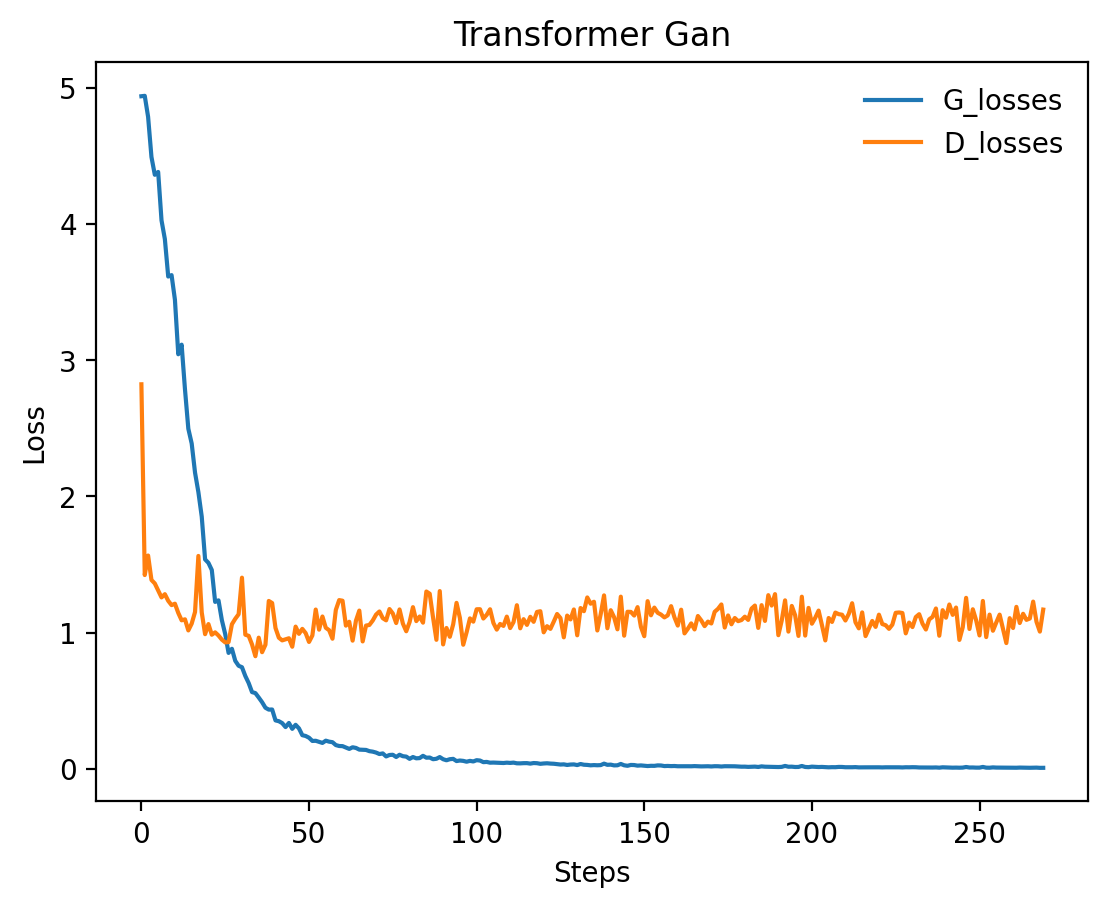

In [33]:
# plot losses
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina' # Makes the plots clear on high-res screens
plt.plot(G_losses, label='G_losses')
plt.plot(D_losses, label='D_losses')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.title("Transformer Gan")
plt.legend(frameon=False)
plt.tight_layout
plt.show()

In [34]:
torch.save(netG.state_dict(), "checkpoints/generator_cond.pt")

In [38]:
def generate_sequence(model, prompt, emotion, max_length, temperature=1.0):
    model.eval()  # Set the model to inference mode

    # Tokenize the prompt
    src = prompt.to(device)
    tgt = src[:,0].unsqueeze(1).to(device)  

    for i in range(max_length):
        # Forward pass through the model
        output = model(src, tgt, emotion)  # Add emotion as required
        logits = output[:, -1, :]  # Consider only the last token's output

        # Apply temperature scaling
        probs = softmax_with_temperature(logits, temperature)

        # Sample from the probability distribution
        next_token = torch.multinomial(probs, num_samples=1)
        
        # Append to the sequence
        tgt = torch.cat((tgt, next_token), dim=1)

        # Check for end token
        if next_token.item() == end_token_id:
            break

    return tgt.squeeze().tolist()

In [1]:
for i,batch in enumerate(test_dataset):
    src_data = batch['input'].to(device)
    # tgt_data = src_data[:, 1:].to(device)
    src_data = src_data[:-1]
    emotion = batch['target'].to(device)

    generated_tokens = generate_sequence(netG, src_data.unsqueeze(0), emotion.unsqueeze(0), max_length=256) 
    if emotion.item() == 0:
        emo = 'Q1'
    elif emotion.item() == 1:
        emo = 'Q2'
    elif emotion.item() == 2:
        emo = 'Q3'
    elif emotion.item() == 3:
        emo = 'Q4'
    # midi_encoder_remi.words_to_midi(generated_tokens,f'generated_music_cond/transformer_gan/{emo}/transformer_gan{i}.mid')
    # midi_encoder_remi.words_to_midi(src_data,f'generated_music_cond/original/{emo}/original{i}.mid')
    print(src_data)
    print(generated_tokens)